# X-ray luminosity

Following Navaro et al. 1995 and Cox et al. 2006. 

**copied from Cox et al. 2006**

For each SPH particle, 
$$ { L }_{ X,i }=1.2\times { 10 }^{ -24 }\left( \frac { { m }_{ gas,i } }{ \mu { m }_{ p } }  \right) \frac { { \rho  }_{ i } }{ \mu { m }_{ p } } { \left( \frac { k{ T }_{ i } }{\rm{1 \, keV} }  \right)  }^{ 1/2 }ergs \, { s }^{ -1 },$$

where $m_{p}$ is the proton mass, $\mu$ is the mean molecular weight (0.6 for a fully ionized primordial plasma), and mgas, i, ${ m }_{ gas,i }$,and $T_{i}$ are the mass, density, and temperature of the ith gas particle in cgs units, respectively. Equation (1) assumes that the primary mechanism for X-ray emission is thermal bremsstrahlung, an as- sumption consistent with the zero-metallicity cooling included in the simulation. However, metal-enriched gas with a temperature of $10^{6}\,\rm{K}$ cools primarily through metal-line emission, a mechanismthat ismore efficient and would thus produce amuch larger X-ray luminosity. In this sense, the X-ray emission computed via the equation is a lower limit.

Another criteria (Cox + 06): gas needs to have low density (so without SF) and high temperature. $\rho < 10^{-2} M_{\odot}\rm{pc}^{-3}$ and $T > 10^{5.2}\rm{K}$.

In [1]:
cd /home/hoseung/Work/data/29172/

/media/hoseung/DATA/29172


In [2]:
import load
import numpy as np
import matplotlib.pyplot as plt
import draw

In [3]:
def sim_cluster_region(nout, base='./', region="halo"):
    """
        Make a sim instance and set region by halo or refineparams.
    """
    import load
    import numpy as np
    import tree.halomodule as hmo
    
    s = load.sim.Sim(nout=187)
    hcat = hmo.Halo(nout=187,is_gal=False)
    
    cluster = hcat.data[np.argmax(hcat.data["np"])]
    s.set_ranges(ranges=[[cluster["x"]-cluster["rvir"], cluster["x"]+cluster["rvir"]],
                     [cluster["y"]-cluster["rvir"], cluster["y"]+cluster["rvir"]],
                     [cluster["z"]-cluster["rvir"], cluster["z"]+cluster["rvir"]]])
    
    return s

In [4]:
s = sim_cluster_region(187)
s.add_hydro()

[sim._hilbert_cpulist] No AMR instance,
[sim._hilbert_cpulist] Loading one...
An AMR instance is created
 Sim
Simulation set up.
[Halo.load_info] loading info
[Halo.load_info] nout = 187, base =./
./halo/DM/tree_bricks187


### Useful facts

$$T \ ({\rm Kelvin}) \sim 1.16 \times 10^{7} T \ ({\rm keV}) $$

In [17]:
def resize(X,shape=None):
    """ 
    resizes N-D array X into shape.
    For example,
    2D 100 * 100 array -> 200 * 200
    new = resize(img, [200,200])
    """
    import numpy as np
    if shape==None:
        return X
    m,n = shape
#    print(shape)
#    print(m,n)
    Y = np.zeros((m,n),dtype=type(X[0,0]))
    k = len(X)
    p,q = k/m,k/n
    for i in range(m):
        Y[i,:] = X[i*p,np.int_(np.arange(n)*q)]
    return Y


def pp_cell(cell, npix, info, proj="z",
            dist_in_Mpc = 100,
            verbose=False, autosize=False,
            region=None,
            xmin=None, xmax=None, ymin=None, ymax=None,
            hvar="rho", field_var=None):
    """
    Special version of pp_cell to draw x-ray emission map according to Cox+06.
    
    But not working well :(
    
    
    Accepts cell data and returns 2D projected gas map.
     *position and dx must be in the same unit.

    example
    -------
    >>> gas_map = pp_cell(gal.cell, 200, info)
    >>> plt.imshow(gas_map, origin="lower")
    >>> plt.show()
    -> Without range or region, all cells are taken. 

    >>> region = smp.set_region(centers=[0.,0.,0.], radius=gal.region['radius'])
    >>> gas_map = pp_cell(gal.cell, 200, info, region=region)
    -> cells only inside the region are taken into account.
       *It's a cubic region, not a sphere.

    """
    import numpy as np
    from draw import ppc

    T_cut_in_code_unit = 10**(5.2) / info.unit_T2
    Msun_in_g = 1.989*1e33
    pc_in_cm = 3.26 * 3153600 * 1e10
    rho_cut = 0.01 *Msun_in_g / pc_in_cm**3
    rho_cut_in_code_unit = rho_cut / info.unit_d
    
# Assuming no slice.
    # cells above the temperature cut * below the density cut.
    # Note that no z-axis cut is applied.
    valid = np.where((cell["var4"]/cell["var0"] > T_cut_in_code_unit) & 
                   (cell["var0"] < rho_cut_in_code_unit))[0]
    n_ok = len(valid)
    print("{:.2f}% of cells selected".format(n_ok/ len(cell) * 100))
    print(" usually >90% are hot enough. Around the same number are diffuse enough.")
    
    cell = cell[valid]
    
    sig = 1.0
    sigrange = sig * 2# what is sigrange?
    #
    x = cell["x"]
    y = cell["y"]

    # Cell position
    if (xmin is None) & (xmax is None) & (ymin is None) & (ymax is None):
        if region is not None:
            xmi0, xma0 = region['xr'][0], region['xr'][1]
            ymi0, yma0 = region['yr'][0], region['yr'][1]
        else:
            xmi0, xma0, ymi0, yma0 = min(x), max(x), min(y), max(y)
    if xmi0 is None:
        xmi0 = min(x)
    if xma0 is None:
        xma0 = max(x)
    if ymi0 is None:
        ymi0 = min(y)
    if yma0 is None:
        yma0 = max(y)

    # left and right boundaries of cells
    xl = x - cell['dx']/2*sigrange # array as long as x
    xr = x + cell['dx']/2*sigrange
    yl = y - cell['dx']/2*sigrange
    yr = y + cell['dx']/2*sigrange

    if n_ok == 0:
        print("No cell is selected")
        return False

    dx = cell["dx"]#[val]
    
# Because the luminosity is an extensive property, 
# calculate for each cell and sum along the line of sight.

    # For fully ionized gas, mean molecular weight (mu) is 0.6
    mp = 1.6726219 * 10**(-24)# mass of proton in g.
    mu_mp = 0.6 * mp
    
    mgas_in_g = cell["var0"] * cell["dx"]**3 * s.info.unit_d * s.info.unit_l ** 3 #/ (1.989*1e33)
    k_boltmann = 1.38064852 * 10**(-16) # in erg K^-1 unit.
    
    # It's in this form to be consistent with the equation above, 
    # but the computation will be faster if better organized.
    sden = 1.2 * 10**(-24) * (mgas_in_g / mu_mp) \
         * (cell["var0"]* s.info.unit_d / mu_mp) \
         * np.sqrt(k_boltmann*cell["var4"]/cell["var0"]*s.info.unit_T2 * (1.16*1e7)) #/ dist_in_Mpc**3
    
    mindx = min(dx)

    xmi = np.floor(xmi0/mindx)*mindx
    xma = np.ceil(xma0/mindx)*mindx
    nx = np.round((xma-xmi-mindx)/mindx).astype(np.int32)

    ymi = np.floor(ymi0/mindx)*mindx
    yma = ymi + mindx*nx + mindx
    ny = np.round((yma-ymi-mindx)/mindx).astype(np.int32)

    # Assum no smoothing.
    ixmi = np.round(xmi/mindx).astype(np.int32) # int
    iymi = np.round(ymi/mindx).astype(np.int32)

    ixl = np.round(xl / mindx).astype(np.int32) - ixmi
    ixr = np.round(xr / mindx).astype(np.int32) - ixmi -1
    iyl = np.round(yl / mindx).astype(np.int32) - iymi
    iyr = np.round(yr / mindx).astype(np.int32) - iymi -1
    iin = np.where((ixr >= 0) & (ixl <= nx-1) & (iyr >= 0) & (iyl <= ny-1))[0].astype(np.int32)
    # What does it mean?

    fd = ixl < 0
    if len(fd) > 0:
        ixl[fd] = 0
    fd = ixr > nx - 1
    if len(fd) > 0:
        ixr[fd] = nx -1
        fd = ixl < 0
    if len(fd) > 0:
        ixl[fd] = 0
    fd = ixl < 0
    if len(fd) > 0:
        ixl[fd] = 0

    ixl[ixl < 0] = 0
    ixr[ixr > nx -1] = nx -1
    iyl[iyl < 0] = 0
    iyr[iyr > ny - 1] = ny -1

    fd = np.where((ixl >= 0) & (ixr >=0) & (ixl > ixr))[0]
    if len(fd):
        ixr[fd] = ixl[fd]
    fd = np.where((iyl >= 0) & (iyr >=0) & (iyl > iyr))[0]
    if len(fd):
        iyr[fd] = iyl[fd]

    return resize(ppc.col(iin,
            ixl, ixr, iyl, iyr,
            sden, nx, ny), [npix,npix]) 

In [18]:
xraymap = pp_cell(s.hydro.cell, 400, s.info, proj="z", verbose=False, autosize=False)

97.83% of cells selected
 usually >90% are hot enough. Around the same number are diffuse enough.


/home/hoseung/mypy/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
tmap = draw.pp.pp_cell(s.hydro.cell, 400, s.info, autosize=False, hvar="temp")

/home/hoseung/Work/pyclusterevol/draw/pp.py:760: RuntimeWarning: invalid value encountered in true_divide
  nx, ny, column), [npix,npix])
/home/hoseung/Work/pyclusterevol/draw/pp.py:452: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i,:] = X[i*p,np.int_(np.arange(n)*q)]


In [12]:
denmap = draw.pp.pp_cell(s.hydro.cell, 400, s.info, autosize=False, hvar="rho")

/home/hoseung/Work/pyclusterevol/draw/pp.py:760: RuntimeWarning: invalid value encountered in true_divide
  nx, ny, column), [npix,npix])
/home/hoseung/Work/pyclusterevol/draw/pp.py:452: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i,:] = X[i*p,np.int_(np.arange(n)*q)]


In [13]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(np.log10(denmap), cmap='Reds')
axs[0,1].imshow(np.log10(xraymap), cmap='Reds')
axs[1,0].imshow(np.log10(tmap), cmap='Reds')
plt.savefig("den_xray_temp_maps.png", dpi=200)

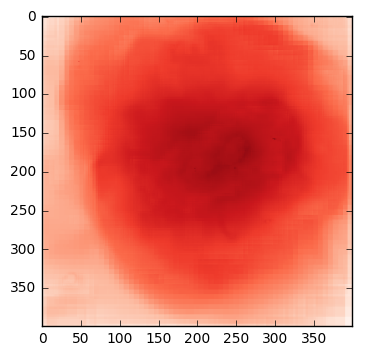

In [20]:
plt.imshow(np.log10(xraymap), cmap='Reds')
plt.show()

## To do 

Now, put the cluster at certain distance. 
The values are in erg/s unit, and X-ray observations usually intergrates over thousands of seconds to get 1e-4 count per second per arcsec^2.
For example, See figure 10, 11 of the paper http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1503.01121 .